# Reinforcement Learning Individual Assignment Deliverable I - Sebastian Lee

Note: Sarsa(λ) Agent is implemented as the third agent. Sarsa agent is shown as the second agent.

## Install Packages

In [ ]:
!pip install git+https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git

  Cloning https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to /tmp/pip-req-build-jy49a0z6
  Running command git clone --filter=blob:none --quiet https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git /tmp/pip-req-build-jy49a0z6
  Resolved https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to commit ca2797e9270195313423324c9d0f205f6cbb3d28
  Preparing metadata (setup.py) ... done


In [ ]:
# Install packages
import numpy as np
import os, sys
import gymnasium as gym
import time
import random
from collections import defaultdict
import text_flappy_bird_gym
import matplotlib.pyplot as plt

## Implementation of First Agent - Monte Carlo Control

### Define Monte Carlo Control Agent

In [ ]:
class AgentMonteCarloControl:
    def __init__(self, alpha, gamma, epsilon, num_actions, observation_space):
        self.alpha = alpha  # learning rate
        self.gamma = gamma  # discount rate gamma
        self.epsilon = epsilon  # exploration rate epsilon
        self.num_actions = num_actions  # number of actions = 2
        self.max_dx = observation_space[0].n  # max horizontal observation space
        self.max_dy = observation_space[1].n + 3  # max vertical observation space, accounting 0
        self.min_dy = observation_space[1].start - 1  # min vertical observation space, plus minus 12
        self.num_states = self.max_dx * self.max_dy  # number of states
        self.q = np.zeros((self.num_states, self.num_actions))  # Q-table initialization
        self.current_state = None
        self.current_action = None
        self.episode = []
        self.policy = np.zeros(self.num_states, dtype=int)  # Policy initialization
        self.done = False
        self.info = None
        self.rand_generator = np.random.RandomState(42)


    def generate_episode_from_Q(self, env):
        """ generates episodes from q table until done = True
        Args:
            env: game environment
        """
        self.episode = []
        self.done = False
        obs, _ = env.reset()
        self.current_state = self.state_np_converter(obs)

        while not self.done:
            self.current_action = np.random.choice(np.arange(self.num_actions), p=self.get_probability(self.current_state))
            next_obs, reward, self.done, _, self.info = env.step(self.current_action)
            self.episode.append((self.current_state, self.current_action, reward))
            next_state = self.state_np_converter(next_obs)
            self.current_state = next_state


    def get_probability(self, state):
        """ generates probability under epsilon greedy policy
        Args:
            state (np array): the array of bird state dx and dy
        Returns:
            policy (np array): an array of action probability a
        """
        policy_s = np.ones(self.num_actions) * self.epsilon / self.num_actions
        best_action = np.argmax(self.q[state])
        policy_s[best_action] = 1 - self.epsilon + (self.epsilon / self.num_actions)
        self.epsilon *= 0.9999999

        return policy_s


    def update_Q(self):
        """
        updates Q table after an episode is terminated
        """
        for i in range(len(self.episode)):
            state, action, reward = self.episode[i]
            G = sum([r * (self.gamma ** j) for j, (s, a, r) in enumerate(self.episode[i:])])
            old_Q = self.q[state, action]
            self.q[state, action] = old_Q + self.alpha * (G - old_Q)


    def state_np_converter(self, state):
        """ converts 2D coordinate to an integer for 2D Q table
        Args:
            state (np array): the array of bird state dx and dy
        Returns:
            np_state (int): a calculated specific state integer for Q table
        """
        np_state = (state[1] + abs(self.min_dy)) * self.max_dx + state[0]

        return np_state


    def update_policy(self):
        """
        updates policy according to the final Q table
        """
        self.policy = np.argmax(self.q, axis=1)


### Run Flappy Bird with Monte Carlo Control Agent

In [ ]:
# Collect performance data during training
mcc_episode_scores = []

if __name__ == '__main__':
    # Initialize environment
    env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
    action_space_size = env.action_space.n
    observation_space = env.observation_space

    # MCC agent parameters (Modifiable)
    alpha = 0.1  # learning rate
    gamma = 1.0  # discount factor
    epsilon = 0.1  # exploration rate

    # Initialize Monte Carlo control agent
    mcc_agent = AgentMonteCarloControl(alpha, gamma, epsilon, action_space_size, observation_space)

    # Training loop (Modifiable)
    MAX_EPISODES = 50000
    conseq_score_threshold = 100

    # Variable initialization
    episode = 0
    conseq_episodes = 0
    score = 0

    while episode < MAX_EPISODES: # loop runs for MAX_EPISODES
        while True: # runs until done is True

            mcc_agent.generate_episode_from_Q(env) # generates episodes until done = True

            if mcc_agent.done:
                score = mcc_agent.info['score']

                if score >= conseq_score_threshold:
                    conseq_episodes += 1
                else:
                    conseq_episodes = 0

                break  # End the episode if termination condition is met

        mcc_agent.update_Q()  # updates Q table

        mcc_episode_scores.append(score)

        if conseq_episodes == 5:
            break

        episode += 1  # Increment episode counter

    mcc_agent.update_policy() # definite policy is updated according to Q table

    env.close()  # Close the environment after training completes

### Visualize State-Value Function

<Figure size 800x600 with 0 Axes>

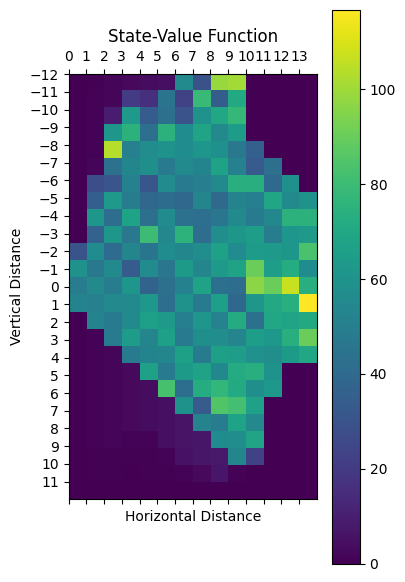

In [ ]:
def plot_state_value_function(agent):
    state_values = np.max(agent.q, axis=1)  # get the maximum Q-value for each state
    state_values = state_values.reshape((agent.max_dy, agent.max_dx))  # reshape to match state space

    # Define the extent for the y-axis to range from -12 to 12
    y_extent = [-12, 12]

    plt.figure(figsize=(8, 6))
    plt.matshow(state_values, interpolation='nearest', extent=[0, agent.max_dx, y_extent[1], y_extent[0]])
    plt.colorbar()
    plt.title('State-Value Function')
    plt.xlabel('Horizontal Distance')
    plt.ylabel('Vertical Distance')
    plt.xticks(np.arange(0, agent.max_dx, 1))
    plt.yticks(np.arange(y_extent[0], y_extent[1], 1))

    plt.show()

plot_state_value_function(mcc_agent)

### Plot Score per Episode

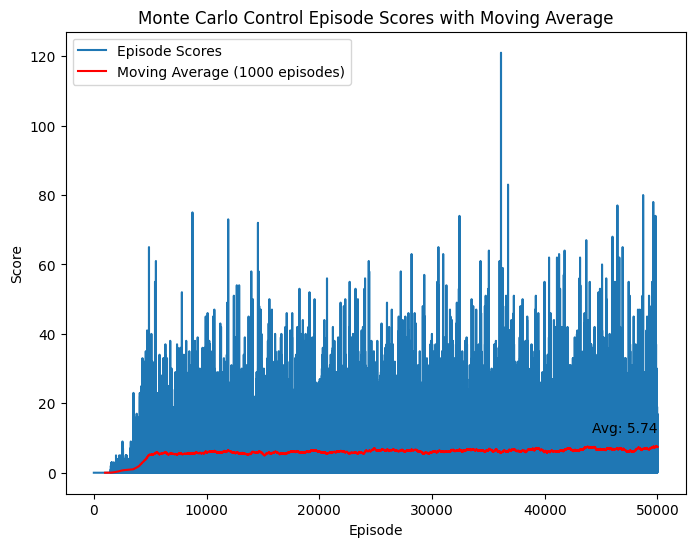

In [ ]:
# Plot episode scores and moving average
window_size = 1000
mcc_moving_avg = np.convolve(mcc_episode_scores, np.ones(window_size)/window_size, mode='valid')
mcc_average_score = np.mean(mcc_episode_scores)

plt.figure(figsize=(8, 6))
plt.plot(mcc_episode_scores, label='Episode Scores')
plt.plot(np.arange(window_size-1, len(mcc_moving_avg) + window_size-1), mcc_moving_avg, color='r', linestyle='-', label=f'Moving Average ({window_size} episodes)')
plt.text(len(mcc_episode_scores) - 1, mcc_average_score + 7, f'Avg: {mcc_average_score:.2f}', color='k', va='center', ha='right')
plt.title('Monte Carlo Control Episode Scores with Moving Average')
plt.xlabel('Episode')
plt.ylabel('Score')
plt.legend()
plt.show()

## Implementation of Second Agent - Sarsa Agent

### Define Sarsa Agent

In [ ]:
class AgentSarsa:
    def __init__(self, alpha, gamma, epsilon, num_actions, observation_space):
        self.alpha = alpha  # learning rate alpha
        self.gamma = gamma  # discount factor gamma
        self.epsilon = epsilon  # exploration rate epsilon
        self.num_actions = num_actions # number of actions = 2
        self.max_dx = observation_space[0].n # max horizontal observation space
        self.max_dy = observation_space[1].n + 3 # max vertical observation space, accounting 0
        self.min_dy = observation_space[1].start - 1 # min vertical observation space, plus minus 12
        self.num_states = (self.max_dx) * (self.max_dy) # number of states = 322
        self.q = np.zeros((self.num_states, self.num_actions))  # Q-table initialization
        self.prev_state = None
        self.prev_action = None
        self.rand_generator = np.random.RandomState(42)


    def agent_start(self, state):
        """ initiates Sarsa agent
        Args:
            state (np array): the array of bird state dx and dy
        Returns:
            action (int): an action with the highest value
        """
        action = self.policy(state)

        self.prev_state = self.state_np_converter(state)
        self.prev_action = action

        return action


    def agent_step(self, state, action, reward):
        """ applies Sarsa algorithm
        Args:
            state (np array): the array of bird state dx and dy
            action (np array): the next action
            reward (int): the reward of next action
        """
        next_state = self.state_np_converter(state)
        current_Q = self.q[self.prev_state][self.prev_action]
        next_Q = self.q[next_state][action]

        self.q[self.prev_state][self.prev_action] += self.alpha * (reward + self.gamma * next_Q - current_Q)

        self.prev_state = next_state
        self.prev_action = action


    def agent_end(self, reward):
        """ applies Sarsa algorithm at the end
        Args:
            reward (int): the reward of last action
        """
        current_Q = self.q[self.prev_state][self.prev_action]

        self.q[self.prev_state][self.prev_action] += self.alpha * (reward - current_Q)


    def policy(self, state):
        """ applies epsilon greedy policy
        Args:
            state (np array): the array of bird state dx and dy
        Returns:
            action (int): an action with the highest value
        """
        # Epsilon-greedy policy
        if np.random.uniform(0, 1) < self.epsilon:
            # Exploration
            action = np.random.randint(0, self.num_actions)
        else:
            # Exploitation
            converted_state = self.state_np_converter(state)
            action = self.argmax(self.q[converted_state])

        self.epsilon *= 0.9999999

        return action


    def state_np_converter(self, state):
        """ converts 2D coordinate to an integer for 2D Q table
        Args:
            q_values (np array): the array of action-values
        Returns:
            np_state (int): a calculated specific state integer for Q table
        """
        np_state = (state[1] + abs(self.min_dy)) * self.max_dx + state[0]

        return np_state


    def argmax(self, q_values):
        """ argmax with random tie-breaking
        Args:
            q_values (np array): the array of action-values
        Returns:
            action (int): an action with the highest value
        """
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)

### Run Flappy Bird with Sarsa Agent

In [ ]:
# Collect performance data during training
sarsa_episode_scores = []

if __name__ == '__main__':
    # Initialize environment
    env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)

    # SARSA agent parameters (Modifiable)
    alpha = 0.1  # learning rate
    gamma = 1.0  # discount factor
    epsilon = 0.1  # exploration rate

    action_space_size = env.action_space.n
    observation_space = env.observation_space

    # Initialize SARSA agent
    sarsa_agent = AgentSarsa(alpha, gamma, epsilon, action_space_size, observation_space)

    # Training loop (Modifiable)
    MAX_EPISODES = 50000
    conseq_score_threshold = 100

    # Variable initialization
    episode = 0
    conseq_episodes = 0
    score = 0

    while episode < MAX_EPISODES: # loop runs for MAX_EPISODES
        obs, _ = env.reset()  # Reset environment for a new episode
        action = sarsa_agent.agent_start(obs)  # Start the episode with the initial action

        while True:
            # Interact with the environment and observe reward and next state
            next_obs, reward, done, _, info = env.step(action)

            # Update SARSA agent based on observed reward and transition
            next_action = sarsa_agent.policy(next_obs)  # Select next action using agent's policy

            if not done:
                sarsa_agent.agent_step(next_obs, next_action, reward)

            action = next_action

            if done:
                sarsa_agent.agent_end(reward)

                score = info['score']

                if score >= conseq_score_threshold:
                    conseq_episodes += 1

                else:
                    conseq_episodes = 0

                break  # End the episode if termination condition is met

        sarsa_episode_scores.append(score)

        if conseq_episodes == 5:
            break

        episode += 1  # Increment episode counter

    env.close()  # Close the environment after training completes

### Visualize State-Value Function

<Figure size 800x600 with 0 Axes>

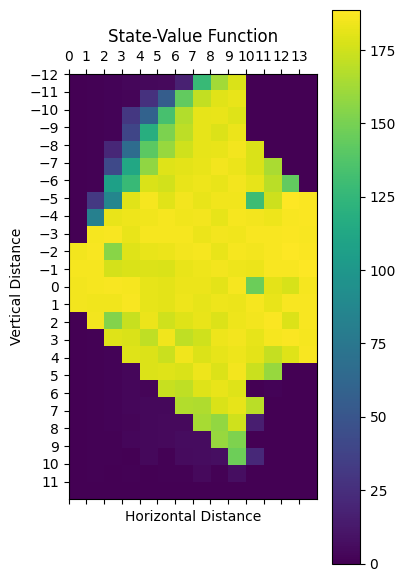

In [ ]:
def plot_state_value_function(agent):
    state_values = np.max(agent.q, axis=1)  # get the maximum Q-value for each state
    state_values = state_values.reshape((agent.max_dy, agent.max_dx))  # reshape to match state space

    # Define the extent for the y-axis to range from -12 to 12
    y_extent = [-12, 12]

    plt.figure(figsize=(8, 6))
    plt.matshow(state_values, interpolation='nearest', extent=[0, agent.max_dx, y_extent[1], y_extent[0]])
    plt.colorbar()
    plt.title('State-Value Function')
    plt.xlabel('Horizontal Distance')
    plt.ylabel('Vertical Distance')
    plt.xticks(np.arange(0, agent.max_dx, 1))
    plt.yticks(np.arange(y_extent[0], y_extent[1], 1))

    plt.show()

plot_state_value_function(sarsa_agent)

### Plot Score per Episode

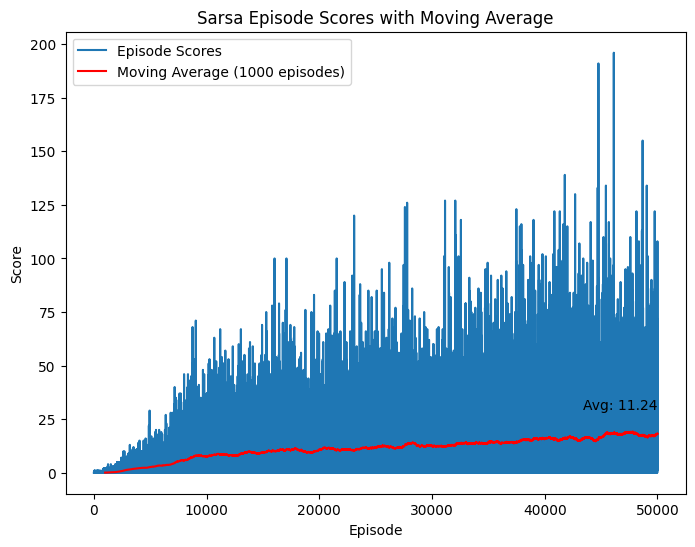

In [ ]:
# Plot episode scores and moving average
window_size = 1000
sarsa_moving_avg = np.convolve(sarsa_episode_scores, np.ones(window_size)/window_size, mode='valid')
sarsa_average_score = np.mean(sarsa_episode_scores)

plt.figure(figsize=(8, 6))
plt.plot(sarsa_episode_scores, label='Episode Scores')
plt.plot(np.arange(window_size-1, len(sarsa_moving_avg) + window_size-1), sarsa_moving_avg, color='r', linestyle='-', label=f'Moving Average ({window_size} episodes)')
plt.text(len(sarsa_episode_scores) - 1, sarsa_average_score + 20, f'Avg: {sarsa_average_score:.2f}', color='k', va='center', ha='right')
plt.title('Sarsa Episode Scores with Moving Average')
plt.xlabel('Episode')
plt.ylabel('Score')
plt.legend()
plt.show()

## Comparison Between Monte Carlo Control and Sarsa Algorithms

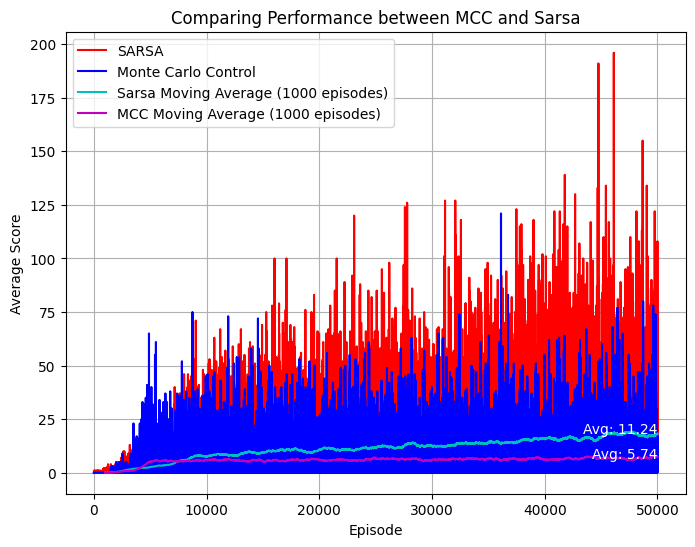

In [ ]:
def plot_comparative_performance(scores_mc, scores_sarsa):
    window_size = 1000

    mcc_moving_avg = np.convolve(scores_mc, np.ones(window_size)/window_size, mode='valid')
    mcc_average_score = np.mean(scores_mc)

    sarsa_moving_avg = np.convolve(scores_sarsa, np.ones(window_size)/window_size, mode='valid')
    sarsa_average_score = np.mean(scores_sarsa)


    episodes = range(1, len(scores_mc) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(episodes, scores_sarsa, label='SARSA', linestyle='-', color='red')
    plt.plot(episodes, scores_mc, label='Monte Carlo Control', linestyle='-', color='blue')

    sarsa_average_score = np.mean(scores_sarsa)
    # plt.axhline(y=sarsa_average_score, color='c', linestyle='--', label='Sarsa Average Score')
    plt.plot(np.arange(window_size-1, len(sarsa_moving_avg) + window_size-1), sarsa_moving_avg, color='c', linestyle='-', label=f'Sarsa Moving Average ({window_size} episodes)')
    plt.text(len(scores_sarsa) - 1, sarsa_average_score + 9, f'Avg: {sarsa_average_score:.2f}', color='w', va='center', ha='right')

    mcc_average_score = np.mean(scores_mc)
    # plt.axhline(y=mcc_average_score, color='m', linestyle='--', label='MCC Average Score')
    plt.plot(np.arange(window_size-1, len(mcc_moving_avg) + window_size-1), mcc_moving_avg, color='m', linestyle='-', label=f'MCC Moving Average ({window_size} episodes)')
    plt.text(len(scores_mc) - 1, mcc_average_score + 3, f'Avg: {mcc_average_score:.2f}', color='w', va='center', ha='right')

    plt.title('Comparing Performance between MCC and Sarsa')
    plt.xlabel('Episode')
    plt.ylabel('Average Score')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_comparative_performance(mcc_episode_scores, sarsa_episode_scores)

## Parameter Sweeps

In [ ]:
# Helper function

def moving_average(data, window_size):
    """
    Calculate the moving average of data
    """
    moving_avg = np.convolve(data, np.ones(window_size) / window_size, mode='valid')

    return moving_avg

### Parameter Sweeps for Monte Carlo Control

In [ ]:
def mcc_parameter_sweep(alpha, gamma, epsilon, max_episodes=10000):
    # Initialize environment
    env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
    action_space_size = env.action_space.n
    observation_space = env.observation_space

    # Initialize Monte Carlo control agent
    mcc_agent = AgentMonteCarloControl(alpha, gamma, epsilon, action_space_size, observation_space)

    # Variable initialization
    episode = 0
    score = 0
    episode_scores = []

    while episode < max_episodes:
        while True:
            mcc_agent.generate_episode_from_Q(env)

            if mcc_agent.done:
                score = mcc_agent.info['score']

                break  # End the episode if termination condition is met

        mcc_agent.update_Q()

        episode_scores.append(score)

        episode += 1  # Increment episode counter

    mcc_agent.update_policy()

    env.close()

    return episode_scores

### Plot Monte Carlo Control Parameter Sweep Results

#### Alpha - Learning Rate

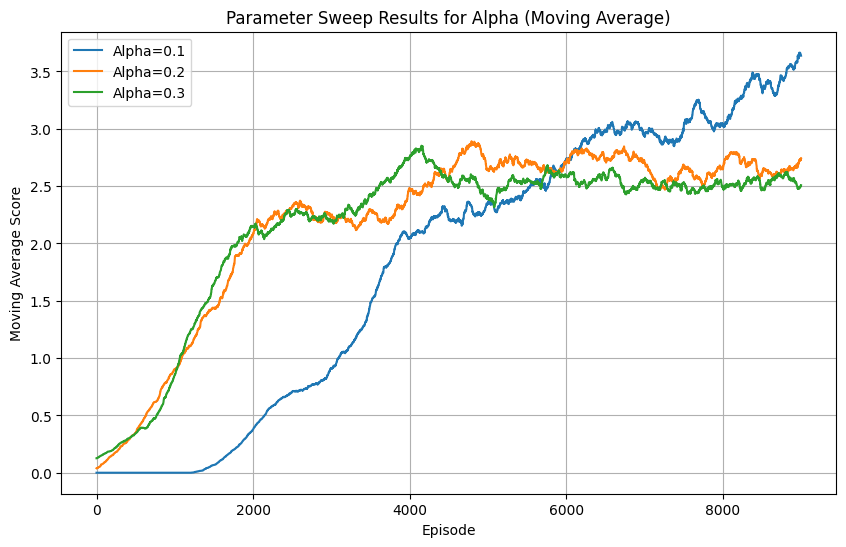

In [ ]:
# Perform parameter sweep for alpha
alphas = [0.1, 0.2, 0.3]
window_size = 1000  # Define the window size for moving average
scores_alpha = []

for alpha in alphas:
    scores = mcc_parameter_sweep(alpha, 1.0, 0.1)  # Fixed gamma and epsilon for this sweep
    scores_avg = moving_average(scores, window_size)
    scores_alpha.append((alpha, scores_avg))

# Plot parameter sweep results for alpha
plt.figure(figsize=(10, 6))

for alpha, scores_avg in scores_alpha:
    plt.plot(scores_avg, label=f'Alpha={alpha}')

plt.title('Parameter Sweep Results for Alpha (Moving Average)')
plt.xlabel('Episode')
plt.ylabel('Moving Average Score')
plt.legend()
plt.grid(True)
plt.show()

#### Gamma - Discount Rate

In [ ]:
# Perform parameter sweep for gamma
gammas = [0.9, 0.95, 0.99]
window_size = 1000
scores_gamma = []

for gamma in gammas:
    scores = mcc_parameter_sweep(0.1, gamma, 0.1)  # Fixed alpha and epsilon
    scores_avg = moving_average(scores, window_size)
    scores_gamma.append((gamma, scores_avg))

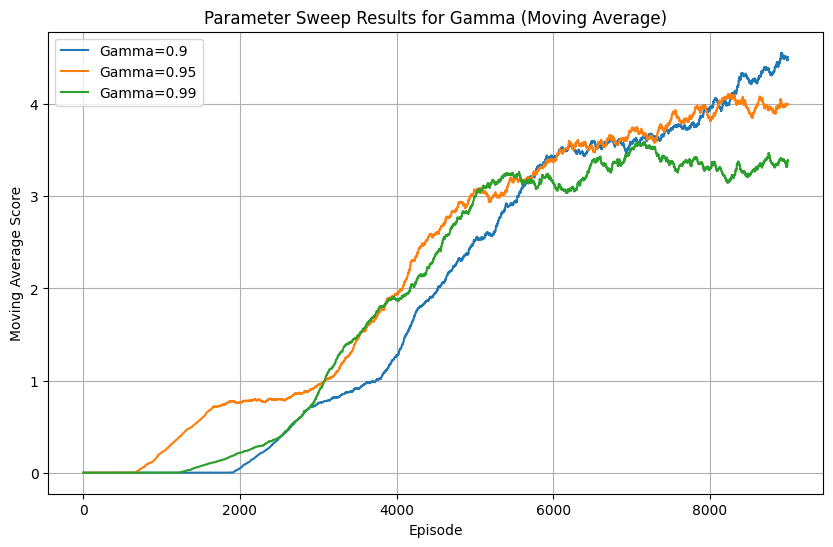

In [ ]:
# Plot parameter sweep results for gamma
plt.figure(figsize=(10, 6))

for gamma, scores_avg in scores_gamma:
    plt.plot(scores_avg, label=f'Gamma={gamma}')

plt.title('Parameter Sweep Results for Gamma (Moving Average)')
plt.xlabel('Episode')
plt.ylabel('Moving Average Score')
plt.legend()
plt.grid(True)
plt.show()

#### Epsilon - Exploration Rate

In [ ]:
# Perform parameter sweep for epsilon
epsilons = [0.05, 0.1, 0.15]
window_size = 1000
scores_epsilon = []

for epsilon in epsilons:
    scores = mcc_parameter_sweep(0.1, 1.0, epsilon)  # Fixed alpha and gamma
    scores_avg = moving_average(scores, window_size)
    scores_epsilon.append((epsilon, scores_avg))

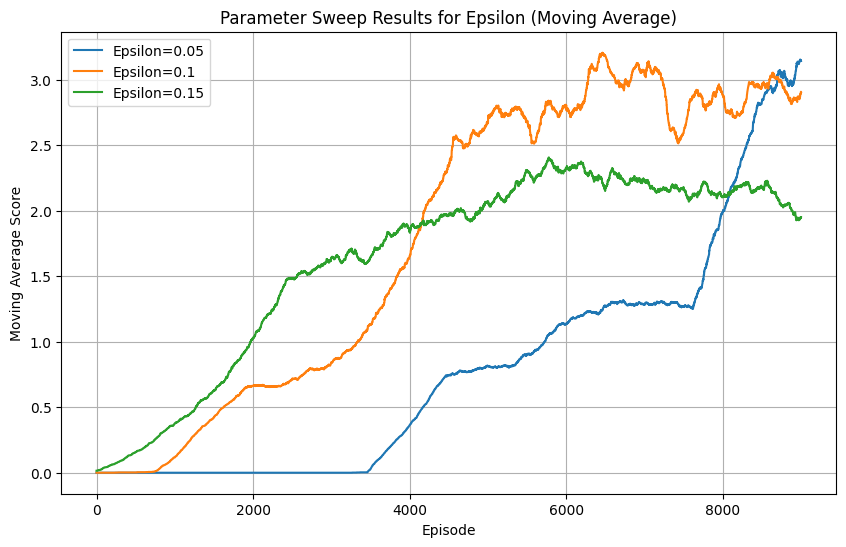

In [ ]:
# Plot parameter sweep results for epsilon
plt.figure(figsize=(10, 6))

for epsilon, scores_avg in scores_epsilon:
    plt.plot(scores_avg, label=f'Epsilon={epsilon}')

plt.title('Parameter Sweep Results for Epsilon (Moving Average)')
plt.xlabel('Episode')
plt.ylabel('Moving Average Score')
plt.legend()
plt.grid(True)
plt.show()

### Parameter Sweeps for Sarsa Agent

In [ ]:
def sarsa_parameter_sweep(alpha, gamma, epsilon, max_episodes=10000):
    # Initialize environment
    # env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
    action_space_size = env.action_space.n
    observation_space = env.observation_space

    # Initialize SARSA agent
    sarsa_agent = AgentSarsa(alpha, gamma, epsilon, action_space_size, observation_space)

    # Variable initialization
    episode = 0
    score = 0
    episode_scores = []

    while episode < max_episodes:
        obs, _ = env.reset()
        action = sarsa_agent.agent_start(obs)

        while True:
            next_obs, reward, done, _, info = env.step(action)
            next_action = sarsa_agent.policy(next_obs)

            if not done:
                sarsa_agent.agent_step(next_obs, next_action, reward)

            action = next_action

            if done:
                sarsa_agent.agent_end(reward)
                score = info['score']

                break

        episode_scores.append(score)

        episode += 1

    env.close()

    return episode_scores

### Plot Sarsa Parameter Sweep Results

#### Alpha - Learning Rate

In [ ]:
# Perform parameter sweep for alpha
alphas = [0.1, 0.2, 0.3]
window_size = 1000
scores_alpha = []

for alpha in alphas:
    scores = sarsa_parameter_sweep(alpha, 1.0, 0.1)  # Fixed gamma and epsilon
    scores_avg = moving_average(scores, window_size)
    scores_alpha.append((alpha, scores_avg))

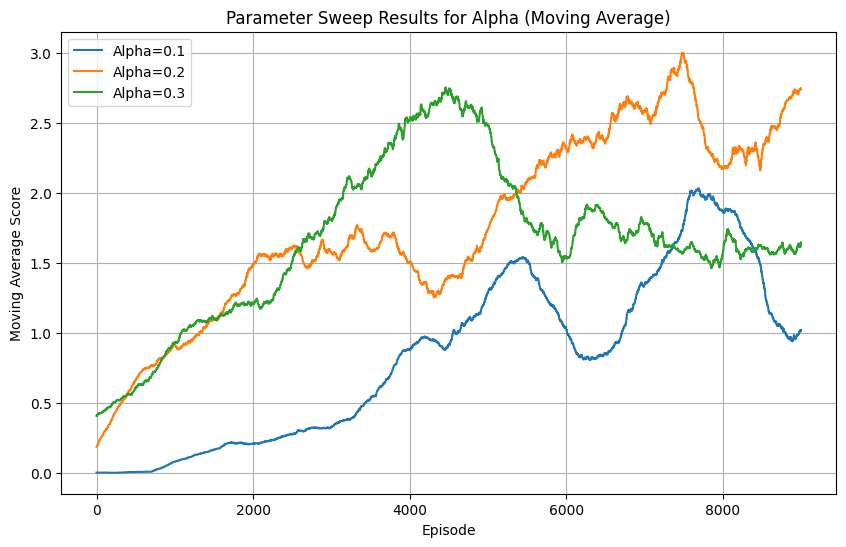

In [ ]:
# Plot parameter sweep results for alpha
plt.figure(figsize=(10, 6))

for alpha, scores_avg in scores_alpha:
    plt.plot(scores_avg, label=f'Alpha={alpha}')

plt.title('Parameter Sweep Results for Alpha (Moving Average)')
plt.xlabel('Episode')
plt.ylabel('Moving Average Score')
plt.legend()
plt.grid(True)
plt.show()

#### Gamma - Discount Rate

In [ ]:
# Perform parameter sweep for gamma
gammas = [0.9, 0.95, 0.99]
window_size = 1000
scores_gamma = []

for gamma in gammas:
    scores = sarsa_parameter_sweep(0.1, gamma, 0.1)  # Fixed alpha and epsilon
    scores_avg = moving_average(scores, window_size)
    scores_gamma.append((gamma, scores_avg))

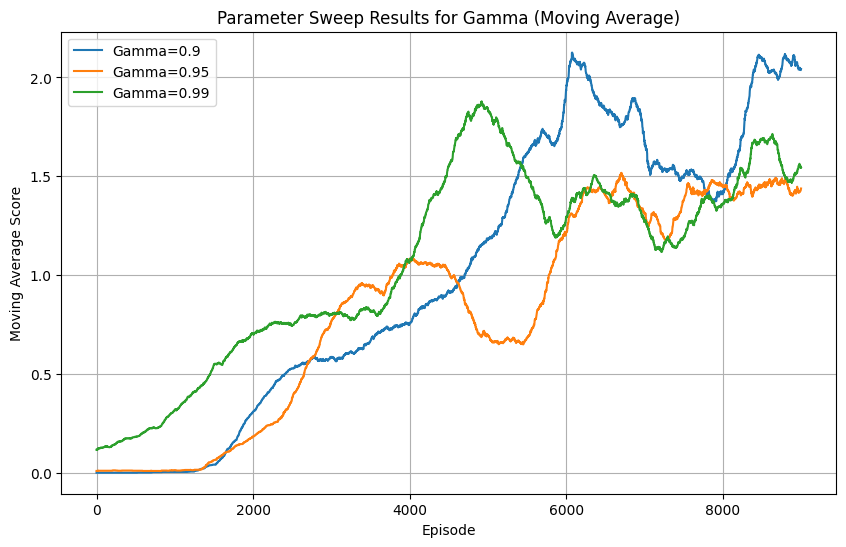

In [ ]:
# Plot parameter sweep results for gamma
plt.figure(figsize=(10, 6))

for gamma, scores_avg in scores_gamma:
    plt.plot(scores_avg, label=f'Gamma={gamma}')

plt.title('Parameter Sweep Results for Gamma (Moving Average)')
plt.xlabel('Episode')
plt.ylabel('Moving Average Score')
plt.legend()
plt.grid(True)
plt.show()

#### Epsilon - Exploration Rate

In [ ]:
# Perform parameter sweep for epsilon
epsilons = [0.05, 0.1, 0.15]
window_size = 1000
scores_epsilon = []

for epsilon in epsilons:
    scores = sarsa_parameter_sweep(0.1, 1.0, epsilon)  # Fixed alpha and gamma
    scores_avg = moving_average(scores, window_size)
    scores_epsilon.append((epsilon, scores_avg))

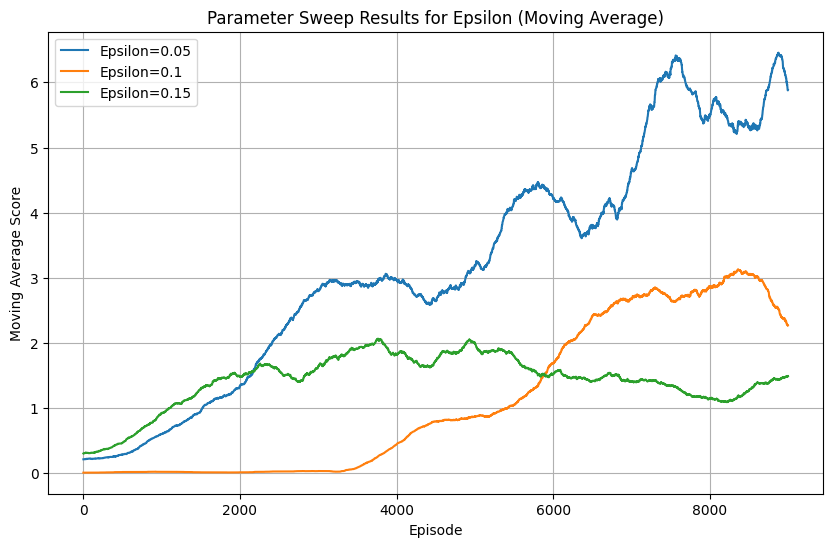

In [ ]:
# Plot parameter sweep results for epsilon
plt.figure(figsize=(10, 6))

for epsilon, scores_avg in scores_epsilon:
    plt.plot(scores_avg, label=f'Epsilon={epsilon}')

plt.title('Parameter Sweep Results for Epsilon (Moving Average)')
plt.xlabel('Episode')
plt.ylabel('Moving Average Score')
plt.legend()
plt.grid(True)
plt.show()

## Different TFB Environment Configuration (height = 10, width = 30, gap = 2)

### Monte Carlo Control

In [ ]:
if __name__ == '__main__':
    env_configs = [
        {'height': 15, 'width': 20, 'pipe_gap': 4},
        {'height': 10, 'width': 30, 'pipe_gap': 2},
    ]

    MAX_EPISODES = 1000  # Number of evaluation episodes per environment

    for config in env_configs:
        # Initialize environment
        env = gym.make('TextFlappyBird-v0', **config)

        # Variable initialization for evaluation
        episode = 0
        total_score = 0

        # Evaluate the agent in the current environment
        while episode < MAX_EPISODES:
            obs, _ = env.reset()
            state = mcc_agent.state_np_converter(obs)
            done = False
            score = 0

            while not done:
                action = mcc_agent.policy[state]
                obs, reward, done, _, _ = env.step(action)
                state = mcc_agent.state_np_converter(obs)
                score += reward

            total_score += score
            episode += 1

        # Calculate average score for the current environment
        average_score = total_score / MAX_EPISODES
        print(f"Average score in environment {config}: {average_score}")

        env.close()

Average score in environment {'height': 15, 'width': 20, 'pipe_gap': 4}: 62.912
Average score in environment {'height': 10, 'width': 30, 'pipe_gap': 2}: 40.933


### Sarsa Agent

In [ ]:
if __name__ == '__main__':
    env_configs = [
        {'height': 15, 'width': 20, 'pipe_gap': 4},
        {'height': 10, 'width': 30, 'pipe_gap': 2},
    ]

    MAX_EPISODES = 1000  # Number of evaluation episodes per environment

    for config in env_configs:
        # Initialize environment
        env = gym.make('TextFlappyBird-v0', **config)

        # Variable initialization for evaluation
        episode = 0
        total_score = 0

        # Evaluate the agent in the current environment
        while episode < MAX_EPISODES:
            obs, _ = env.reset()
            action = sarsa_agent.agent_start(obs)
            done = False
            score = 0

            while not done:
                next_obs, reward, done, _, info = env.step(action)
                next_action = sarsa_agent.policy(next_obs)

                if not done:
                    sarsa_agent.agent_step(next_obs, next_action, reward)

                action = next_action
                score += reward

            total_score += score
            episode += 1

        # Calculate average score for the current environment
        average_score = total_score / MAX_EPISODES
        print(f"Average score in environment {config}: {average_score}")

        env.close()

Average score in environment {'height': 15, 'width': 20, 'pipe_gap': 4}: 24.13
Average score in environment {'height': 10, 'width': 30, 'pipe_gap': 2}: 23.476


## Implementation of Third Agent (Actual Second Agent) - Sarsa(λ) Agent

### Define Sarsa(λ) Agent

In [ ]:
class AgentSarsaLambda:
    def __init__(self, alpha, gamma, epsilon, lambd, num_actions, observation_space):
        self.alpha = alpha  # learning rate alpha
        self.gamma = gamma  # discount factor gamma
        self.epsilon = epsilon  # exploration rate epsilon
        self.lambd = lambd
        self.num_actions = num_actions # number of actions = 2
        self.max_dx = observation_space[0].n # max horizontal observation space
        self.max_dy = observation_space[1].n + 3 # max vertical observation space, accounting 0
        self.min_dy = observation_space[1].start - 1 # min vertical observation space, plus minus 12
        self.num_states = (self.max_dx) * (self.max_dy) # number of states = 322
        self.q = np.zeros((self.num_states, self.num_actions))  # Q-table initialization
        self.prev_state = None
        self.prev_action = None
        self.eligibility_traces = np.zeros_like(self.q)
        self.rand_generator = np.random.RandomState(42)


    def agent_start(self, state):
        """ initiates Sarsa lambda agent
        Args:
            state (np array): the array of bird state dx and dy
        Returns:
            action (int): an action with the highest value
        """
        action = self.policy(state)

        self.prev_state = self.state_np_converter(state)
        self.prev_action = action
        self.eligibility_traces.fill(0)

        return action


    def agent_step(self, state, action, reward):
        """ applies Sarsa lambda algorithm
        Args:
            state (np array): the array of bird state dx and dy
            action (np array): the next action
            reward (int): the reward of next action
        """
        next_state = self.state_np_converter(state)
        delta = reward + self.gamma * self.q[next_state][action] - self.q[self.prev_state][self.prev_action]

        self.eligibility_traces[self.prev_state][self.prev_action] += 1

        self.q += self.alpha * delta * self.eligibility_traces
        self.eligibility_traces *= self.gamma * self.lambd

        self.prev_state = next_state
        self.prev_action = action


    def agent_end(self, reward):
        """ applies Sarsa lambda algorithm at the end
        Args:
            reward (int): the reward of last action
        """
        delta = reward - self.q[self.prev_state][self.prev_action]

        self.q[self.prev_state][self.prev_action] += self.alpha * delta * self.eligibility_traces[self.prev_state][self.prev_action]
        self.eligibility_traces *= self.gamma * self.lambd


    def policy(self, state):
        """ applies epsilon greedy policy
        Args:
            state (np array): the array of bird state dx and dy
        Returns:
            action (int): an action with the highest value
        """
        # Epsilon-greedy policy
        if np.random.uniform(0, 1) < self.epsilon:
            # Exploration
            action = np.random.randint(0, self.num_actions)
        else:
            # Exploitation
            converted_state = self.state_np_converter(state)
            action = self.argmax(self.q[converted_state])

        self.epsilon *= 0.9999999

        return action


    def state_np_converter(self, state):
        """ converts 2D coordinate to an integer for 2D Q table
        Args:
            q_values (np array): the array of action-values
        Returns:
            np_state (int): a calculated specific state integer for Q table
        """
        np_state = (state[1] + abs(self.min_dy)) * self.max_dx + state[0]

        return np_state


    def argmax(self, q_values):
        """ argmax with random tie-breaking
        Args:
            q_values (np array): the array of action-values
        Returns:
            action (int): an action with the highest value
        """
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)

### Run Flappy Bird with Sarsa(λ) Agent

In [ ]:
# Collect performance data during training
sarsalambda_episode_scores = []

if __name__ == '__main__':
    # Initialize environment
    env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)

    # SARSA agent parameters (Modifiable)
    alpha = 0.1  # learning rate
    gamma = 1.0  # discount factor
    epsilon = 0.1  # exploration rate
    lambd = 0.9 # elibility traces decay rate

    action_space_size = env.action_space.n
    observation_space = env.observation_space

    # Initialize SARSA Lambda agent
    sarsalambda_agent = AgentSarsaLambda(alpha, gamma, epsilon, lambd, action_space_size, observation_space)

    # Training loop (Modifiable)
    MAX_EPISODES = 50000
    conseq_score_threshold = 100

    # Variable initialization
    episode = 0
    conseq_episodes = 0
    score = 0

    while episode < MAX_EPISODES: # loop runs for MAX_EPISODES
        obs, _ = env.reset()  # Reset environment for a new episode
        action = sarsalambda_agent.agent_start(obs)  # Start the episode with the initial action

        while True:
            # Interact with the environment and observe reward and next state
            next_obs, reward, done, _, info = env.step(action)

            # Update SARSA agent based on observed reward and transition
            next_action = sarsalambda_agent.policy(next_obs)  # Select next action using agent's policy

            if not done:
                sarsalambda_agent.agent_step(next_obs, next_action, reward)

            action = next_action

            if done:
                sarsalambda_agent.agent_end(reward)

                score = info['score']

                if score >= conseq_score_threshold:
                    conseq_episodes += 1

                else:
                    conseq_episodes = 0

                break  # End the episode if termination condition is met

        sarsalambda_episode_scores.append(score)

        if conseq_episodes == 5:
            break

        episode += 1  # Increment episode counter

    env.close()  # Close the environment after training completes

### Visualize State-Value Function

<Figure size 800x600 with 0 Axes>

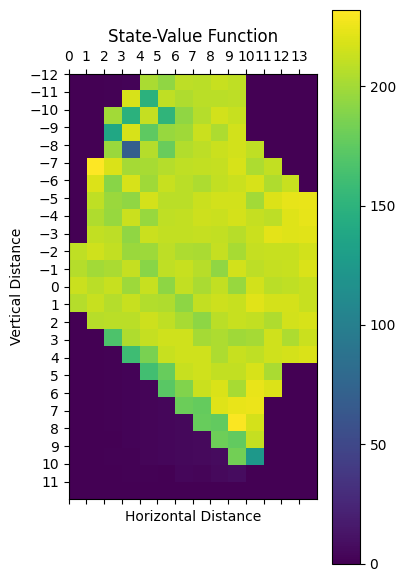

In [ ]:
def plot_state_value_function(agent):
    state_values = np.max(agent.q, axis=1)  # get the maximum Q-value for each state
    state_values = state_values.reshape((agent.max_dy, agent.max_dx))  # reshape to match state space

    # Define the extent for the y-axis to range from -12 to 12
    y_extent = [-12, 12]

    plt.figure(figsize=(8, 6))
    plt.matshow(state_values, interpolation='nearest', extent=[0, agent.max_dx, y_extent[1], y_extent[0]])
    plt.colorbar()
    plt.title('State-Value Function')
    plt.xlabel('Horizontal Distance')
    plt.ylabel('Vertical Distance')
    plt.xticks(np.arange(0, agent.max_dx, 1))
    plt.yticks(np.arange(y_extent[0], y_extent[1], 1))

    plt.show()

plot_state_value_function(sarsalambda_agent)

### Plot Score per Episode

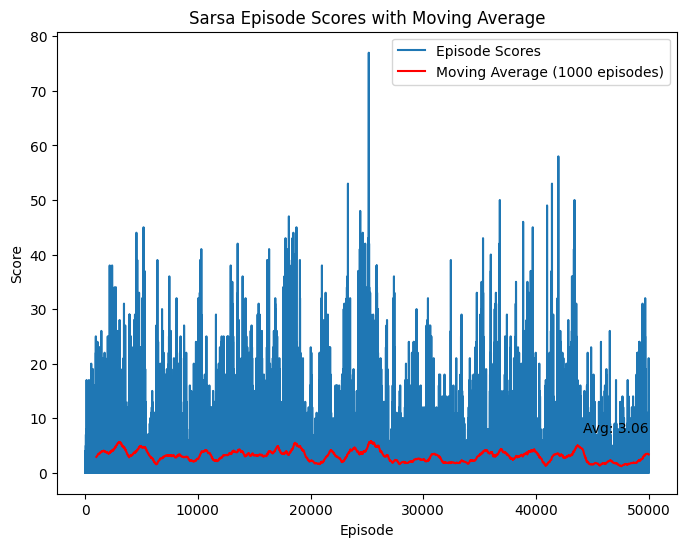

In [ ]:
# Plot episode scores and moving average
window_size = 1000
sarsalambda_moving_avg = np.convolve(sarsalambda_episode_scores, np.ones(window_size)/window_size, mode='valid')
sarsalambda_average_score = np.mean(sarsalambda_episode_scores)

plt.figure(figsize=(8, 6))
plt.plot(sarsalambda_episode_scores, label='Episode Scores')
plt.plot(np.arange(window_size-1, len(sarsalambda_moving_avg) + window_size-1), sarsalambda_moving_avg, color='r', linestyle='-', label=f'Moving Average ({window_size} episodes)')
plt.text(len(sarsalambda_episode_scores) - 1, sarsalambda_average_score + 5, f'Avg: {sarsalambda_average_score:.2f}', color='k', va='center', ha='right')
plt.title('Sarsa Episode Scores with Moving Average')
plt.xlabel('Episode')
plt.ylabel('Score')
plt.legend()
plt.show()